In [43]:
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from scipy.stats import mode
from scipy.stats import f
import pandas as pd
import numpy as np
import warnings

# Montar Dataset

In [12]:
df_medicamentos = pd.read_csv(r"./data/medicamentos_filtrados2.csv").drop(columns = ["Unnamed: 0"])
df_medicamentos["data"] = [pd.Timestamp(day = int(item.split("-")[2]), month = int(item.split("-")[1]), year = int(item.split("-")[0])) for item in df_medicamentos["mes_ano_venda"]]
df_medicamentos = df_medicamentos.loc[:, ["data", "principio_ativo", "quantidade"]]
df_medicamentos = df_medicamentos.loc[df_medicamentos["data"] >= pd.Timestamp(day = 1, month = 6, year = 2019), :].reset_index(drop = True)
df_medicamentos

,data,principio_ativo,quantidade
0,2019-06-01,AMOXICILINA TRI-HIDRATADA,129
1,2019-07-01,AMOXICILINA TRI-HIDRATADA,108
2,2019-08-01,AMOXICILINA TRI-HIDRATADA,130
3,2019-09-01,AMOXICILINA TRI-HIDRATADA,139
4,2019-10-01,AMOXICILINA TRI-HIDRATADA,178
...,...,...,...
205,2021-07-01,ESTOLATO DE ERITROMICINA,1674
206,2021-08-01,ESTOLATO DE ERITROMICINA,1824
207,2021-09-01,ESTOLATO DE ERITROMICINA,1740
208,2021-10-01,ESTOLATO DE ERITROMICINA,1603


In [9]:
df_covid_2020 = pd.read_csv(r"./data/cases-brazil-cities-time_2020.csv").loc[:, ["date", "state", "city", "newCases"]]
df_covid_2020 = df_covid_2020.loc[(df_covid_2020.loc[:, "state"] == "SP")&(df_covid_2020.loc[:, "city"] == "São Paulo/SP"), ["date", "newCases"]].rename(columns = {"date": "data", "newCases": "quantidade"})
df_covid_2020["ano"] = [int(item.split("-")[0]) for item in df_covid_2020["data"]]
df_covid_2020["mes"] = [int(item.split("-")[1]) for item in df_covid_2020["data"]]
df_covid_2020 = df_covid_2020.loc[:, ["quantidade", "ano", "mes"]]

df_covid_2020 = df_covid_2020.groupby(by = ["ano", "mes"]).sum().reset_index()
df_covid_2020["data"] = [pd.Timestamp(day = 1, month = item1, year = item2) for item1, item2 in zip(df_covid_2020["mes"], df_covid_2020["ano"])]
df_covid_2020 = df_covid_2020.loc[:, ["data", "quantidade"]]

df_covid_2021 = pd.read_csv(r"./data/cases-brazil-cities-time_2021.csv").loc[:, ["date", "state", "city", "newCases"]]
df_covid_2021 = df_covid_2021.loc[(df_covid_2021.loc[:, "state"] == "SP")&(df_covid_2021.loc[:, "city"] == "São Paulo/SP"), ["date", "newCases"]].rename(columns = {"date": "data", "newCases": "quantidade"})
df_covid_2021["ano"] = [int(item.split("-")[0]) for item in df_covid_2021["data"]]
df_covid_2021["mes"] = [int(item.split("-")[1]) for item in df_covid_2021["data"]]
df_covid_2021 = df_covid_2021.loc[:, ["quantidade", "ano", "mes"]]

df_covid_2021 = df_covid_2021.groupby(by = ["ano", "mes"]).sum().reset_index()
df_covid_2021["data"] = [pd.Timestamp(day = 1, month = item1, year = item2) for item1, item2 in zip(df_covid_2021["mes"], df_covid_2021["ano"])]
df_covid_2021 = df_covid_2021.loc[:, ["data", "quantidade"]]

df_covid = pd.concat([df_covid_2020, df_covid_2021], ignore_index = True)
df_covid

,data,quantidade
0,2020-02-01,2
1,2020-03-01,1883
2,2020-04-01,16264
3,2020-05-01,41982
4,2020-06-01,66988
5,2020-07-01,70441
6,2020-08-01,60389
7,2020-09-01,34118
8,2020-10-01,24903
9,2020-11-01,32942


In [119]:
def teste_granger(medicamento: str, df_medicamentos: pd.DataFrame, df_covid: pd.DataFrame, lag: int) -> pd.DataFrame:
    warnings.filterwarnings("ignore", category=FutureWarning)
    
    df_granger = df_medicamentos.loc[df_medicamentos["principio_ativo"] == medicamento, :].set_index(keys = ["data"]).join(
        df_covid.set_index(keys = ["data"]),
        how = "inner",
        lsuffix = "_medicamentos"
    ).rename(columns = {"quantidade_medicamentos": "x_medicamentos", "quantidade": "y_covid"}).reset_index().drop(columns = ["principio_ativo"]).loc[:, ["data", "y_covid", "x_medicamentos"]]

    # Ler sobre statsmodels.tsa.stattools.grangercausalitytests
    results = grangercausalitytests(df_granger.drop(columns = ["data"]), maxlag = 3, verbose = False)
        
    f_test_pvalue = results[lag][0]['ssr_ftest'][1]
    values = (f_test_pvalue, lag, results[lag][1][0], results[lag][1][1])
        
    return df_granger, pd.DataFrame({"medicamento": [medicamento], "p-value": [values[0]], "confianca": [100 * (1 - values[0])], "modelo_restrito": [values[2]], "modelo_irrestrito": [values[3]]})

In [147]:
def histograma_irrestrito(residuos: list[float], medicamento: str):
    fig = plt.figure()
    fig.set_size_inches(10, 6)

    plt.hist(residuos, bins = 25)

    plt.title(f"Distribuição dos Resíduo do modelo \"Covid com {medicamento}\"")
    plt.xlabel("Resíduo")
    plt.ylabel("Frequência")

    plt.savefig(f"./graphs/residuos/{medicamento.lower().replace(" ", "_")}.png")
    plt.show()


def histograma_restrito(residuos: list[float]):
    fig = plt.figure()
    fig.set_size_inches(10, 6)

    plt.hist(residuos, bins = 25)

    plt.title(f"Distribuição dos Resíduo do modelo \"Covid sem Medicamento\"")
    plt.xlabel("Resíduo")
    plt.ylabel("Frequência")

    plt.savefig(f"./graphs/residuos/covid_sem_medicamento.png")
    plt.show()

In [150]:
def confronto(model_restrito, modelo_irrestrito, dfs_granger: pd.DataFrame, medicamento: str, lag: int):
    fig = plt.figure()
    fig.set_size_inches(10, 6)
    
    timestamps = dfs_granger[0]["data"]
    dados_reais = dfs_granger[0]["y_covid"]

    plt.plot(timestamps, dados_reais, label = "Valor Real")
    plt.plot(timestamps[lag:], model_restrito.fittedvalues, label = "Valor sem Dados do Medicamento")
    plt.plot(timestamps[lag:], modelo_irrestrito.fittedvalues, label = f"Valor com Dados do Medicamento {medicamento.capitalize().strip()}")

    plt.title(f"Previsão da Série Temporal de Covid no Teste de Granger usando {medicamento.capitalize().strip()}",)
    plt.xlabel("Data")
    plt.ylabel("Casos de Covid")

    plt.legend()
    plt.savefig(f"./graphs/confrontos/{medicamento.lower().replace(" ", "_")}.png")
    plt.show()

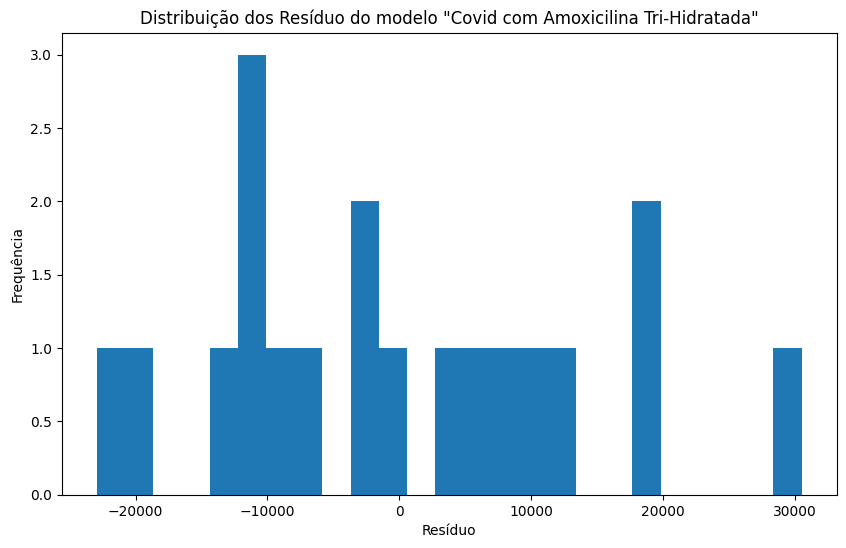

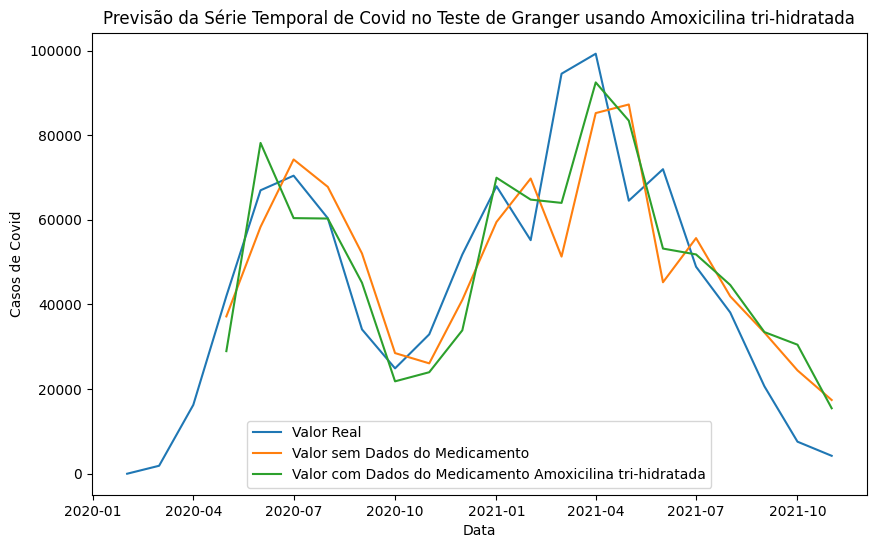

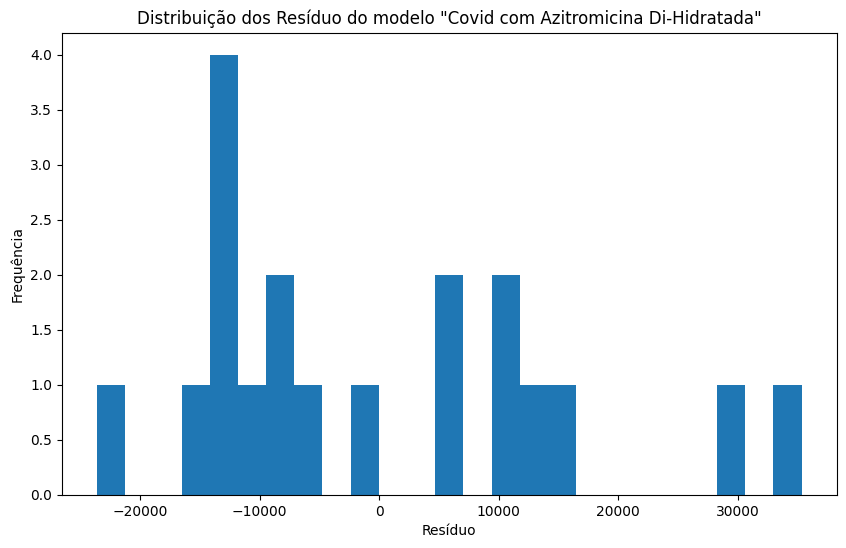

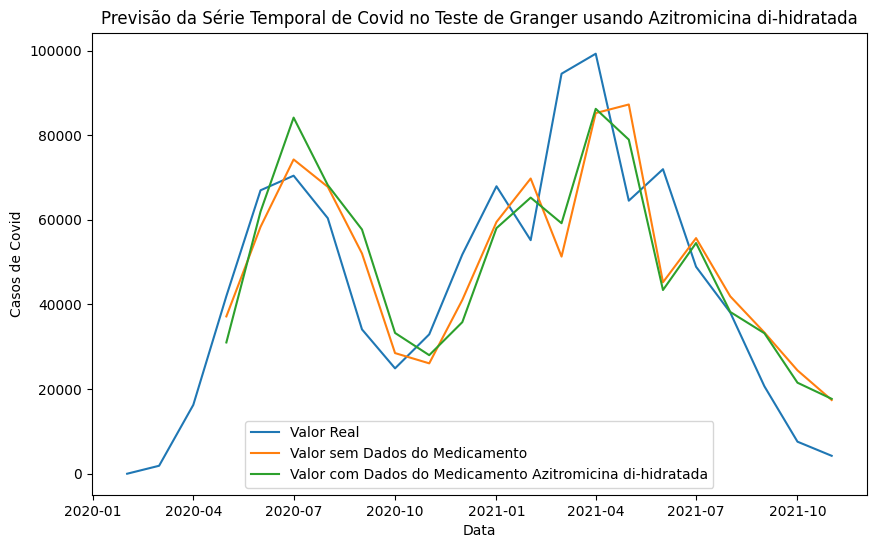

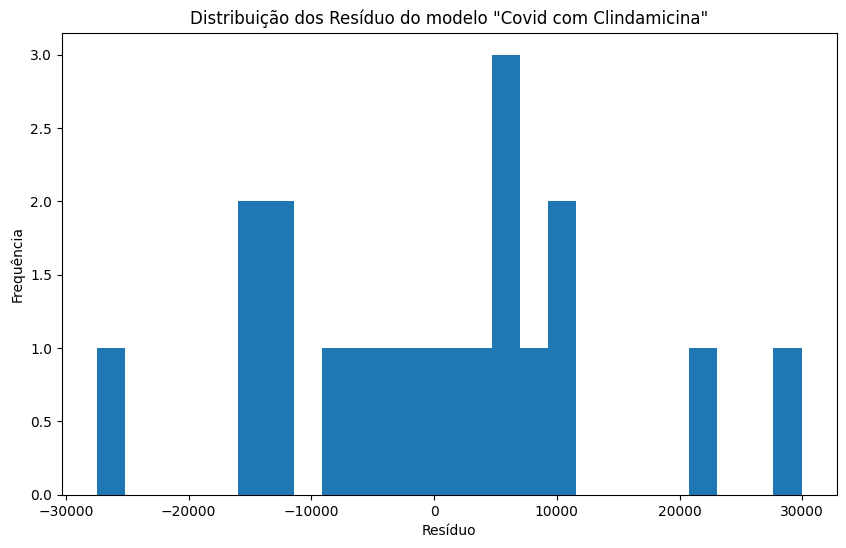

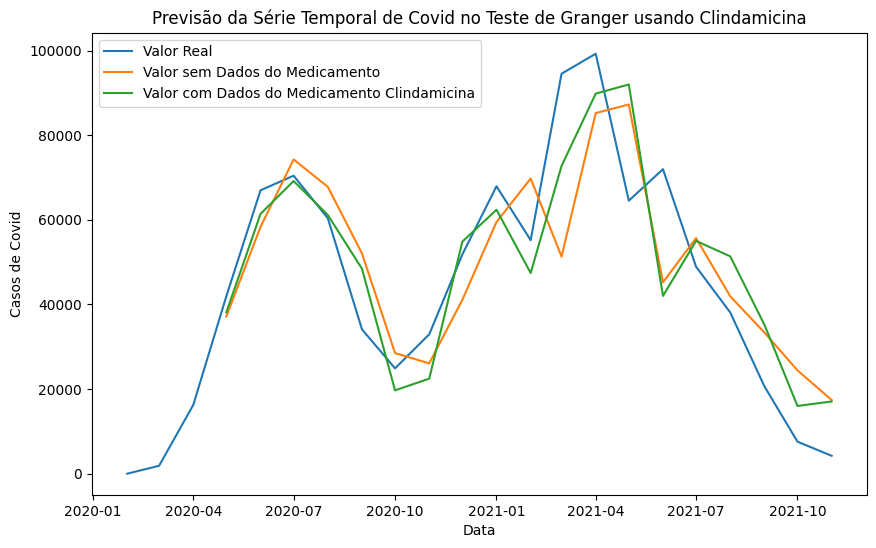

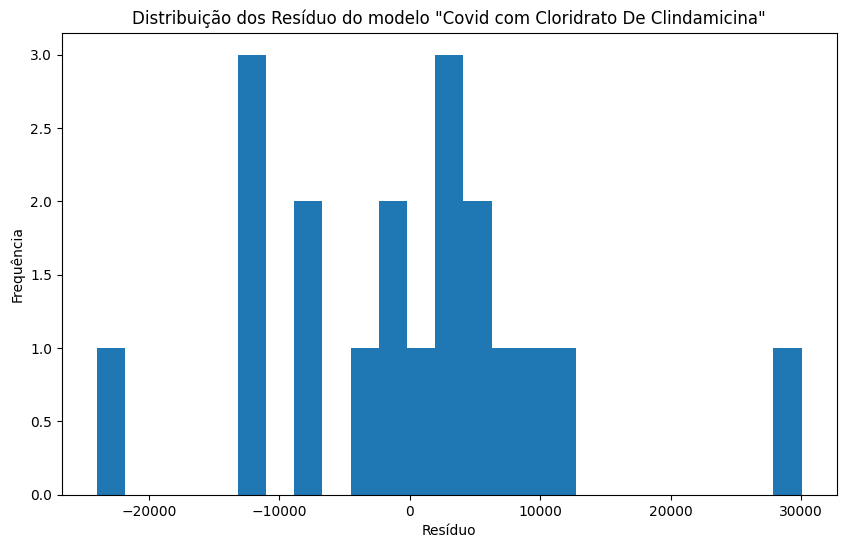

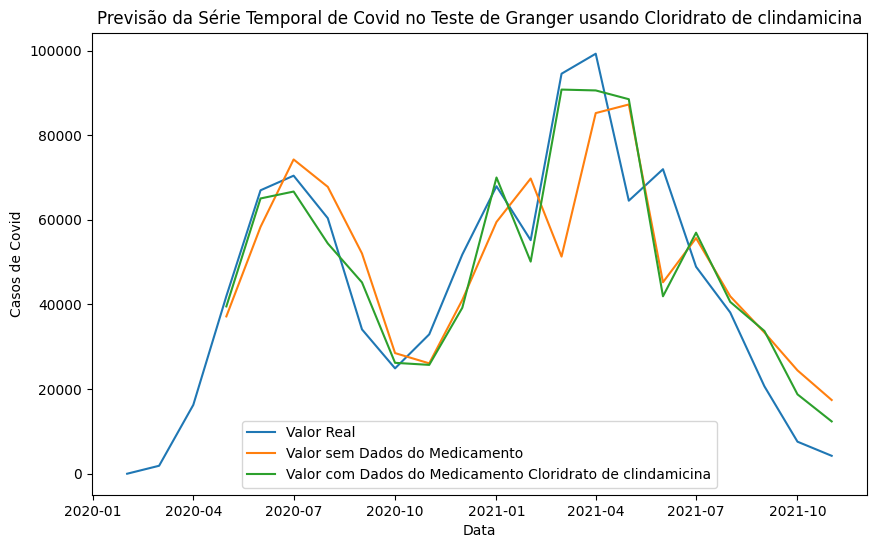

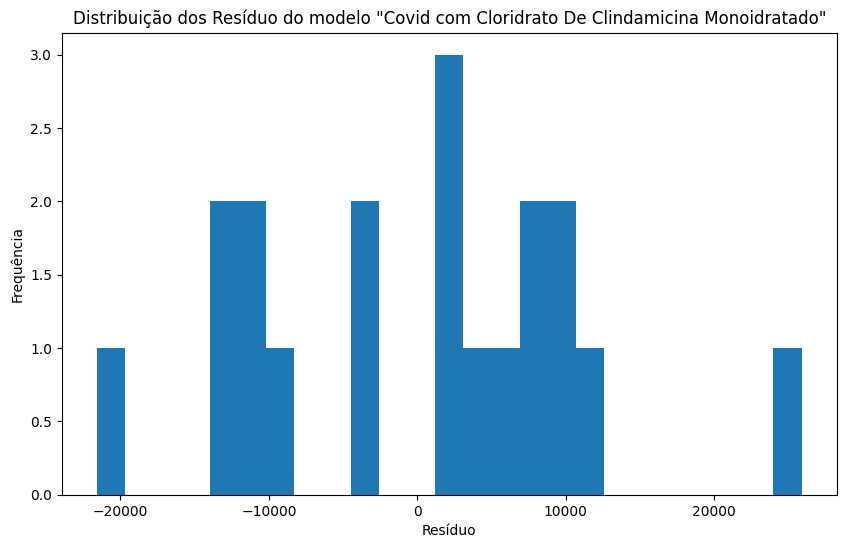

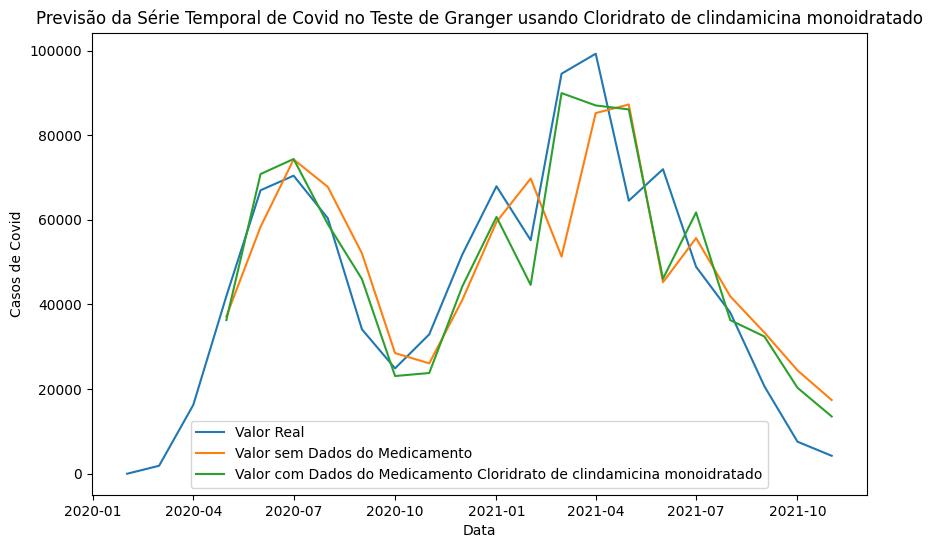

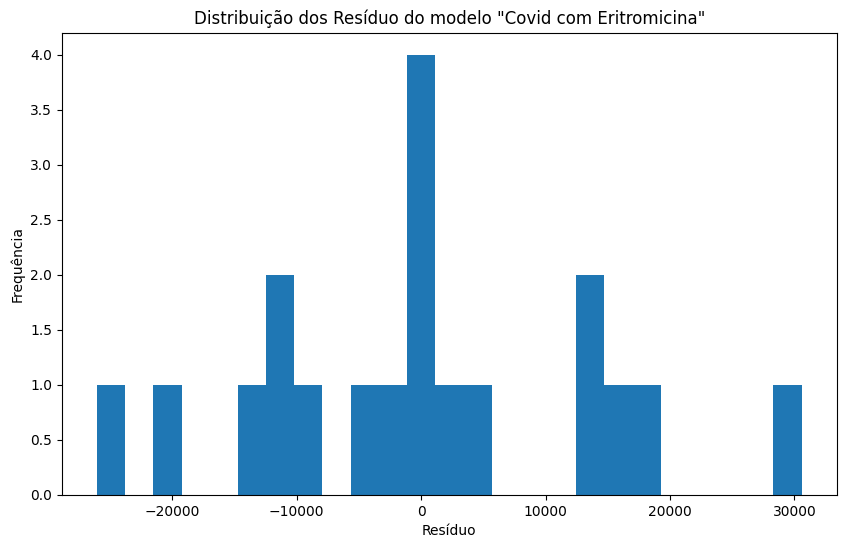

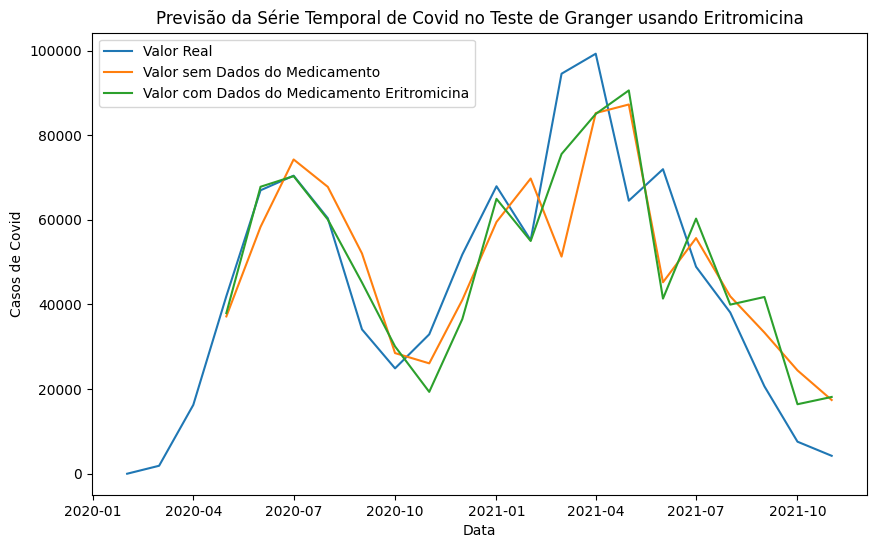

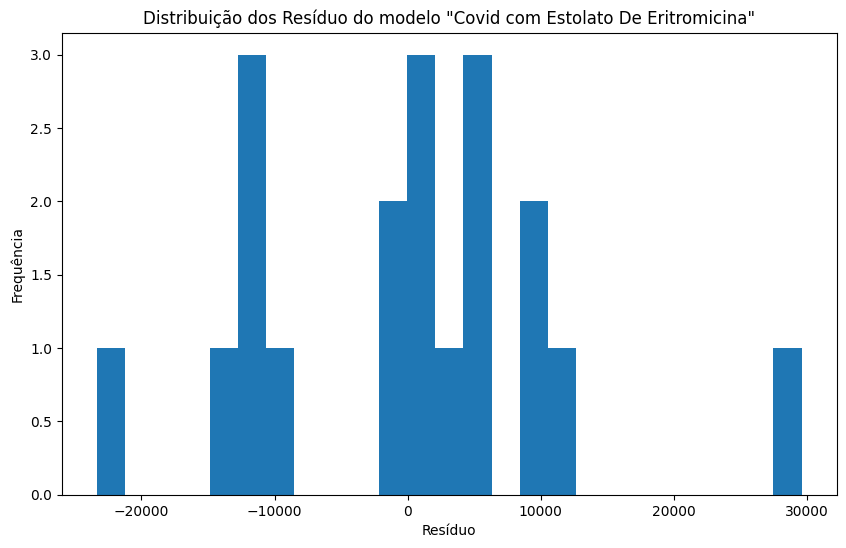

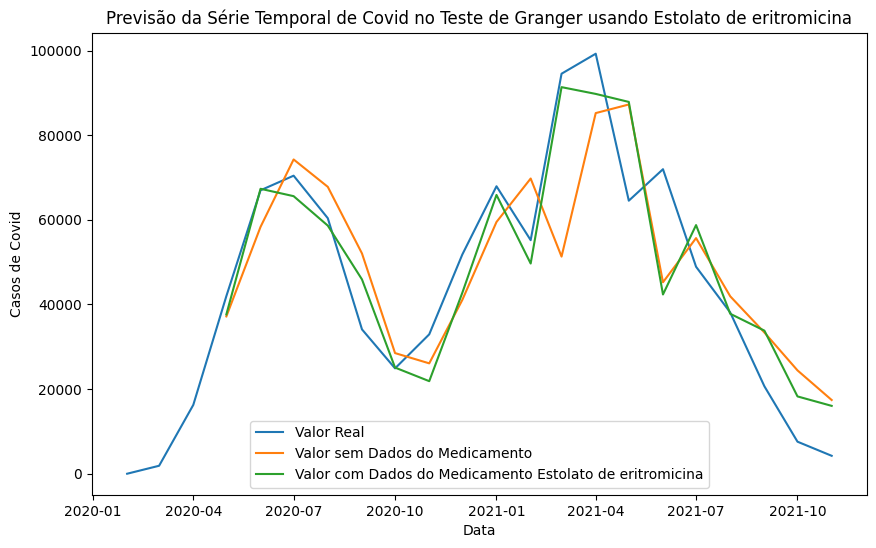

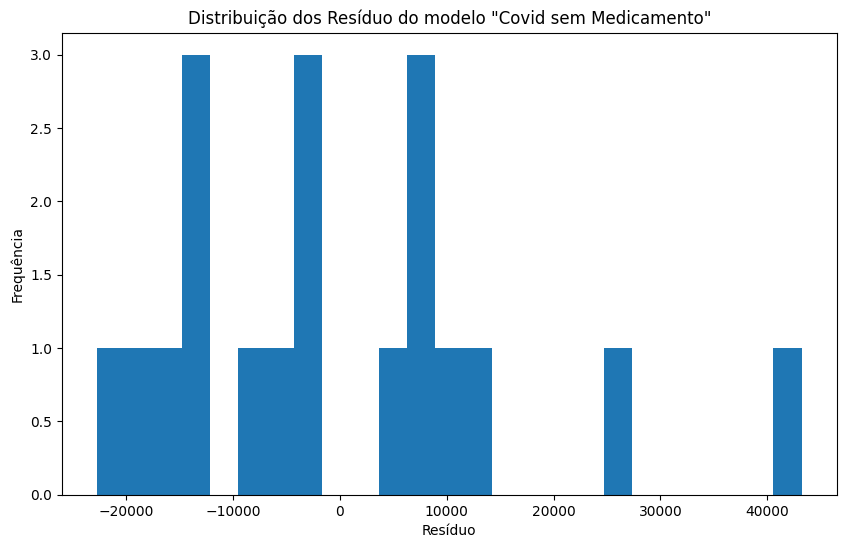

,medicamento,p-value,confianca,modelo_restrito,modelo_irrestrito
0,CLORIDRATO DE CLINDAMICINA MONOIDRATADO,0.028213,97.178659,<statsmodels.regression.linear_model.Regressio...,<statsmodels.regression.linear_model.Regressio...
1,CLORIDRATO DE CLINDAMICINA,0.031740,96.826044,<statsmodels.regression.linear_model.Regressio...,<statsmodels.regression.linear_model.Regressio...
2,ESTOLATO DE ERITROMICINA,0.035188,96.481249,<statsmodels.regression.linear_model.Regressio...,<statsmodels.regression.linear_model.Regressio...
3,CLINDAMICINA,0.191876,80.812426,<statsmodels.regression.linear_model.Regressio...,<statsmodels.regression.linear_model.Regressio...
4,AMOXICILINA TRI-HIDRATADA,0.263288,73.671171,<statsmodels.regression.linear_model.Regressio...,<statsmodels.regression.linear_model.Regressio...
5,ERITROMICINA,0.280161,71.983863,<statsmodels.regression.linear_model.Regressio...,<statsmodels.regression.linear_model.Regressio...
6,AZITROMICINA DI-HIDRATADA,0.776395,22.360453,<statsmodels.regression.linear_model.Regressio...,<statsmodels.regression.linear_model.Regressio...


In [151]:
df_granger_result = None
dfs_granger = []
for medicamento in df_medicamentos["principio_ativo"].unique():
    df_granger, df_temp = teste_granger(medicamento, df_medicamentos, df_covid, 3)
    df_granger_result = pd.concat([df_granger_result, df_temp])
    dfs_granger.append(df_granger)
    
    modelo_restrito = df_granger_result.loc[df_granger_result["medicamento"] == medicamento, "modelo_restrito"].iloc[0]
    modelo_irrestrito = df_granger_result.loc[df_granger_result["medicamento"] == medicamento, "modelo_irrestrito"].iloc[0]
    histograma_irrestrito(modelo_irrestrito.resid, medicamento.title())
    confronto(modelo_restrito, modelo_irrestrito, dfs_granger, medicamento, 3)

histograma_restrito(modelo_restrito.resid)

df_granger_result = df_granger_result.sort_values(by = ["p-value"]).reset_index(drop = True)
df_granger_result

# Modelo Final

Adotando um intervalo de confiança de 95% (padrão literatura)

In [156]:
intervalo_confianca = 95

principios_ativos = np.array(df_granger_result.loc[df_granger_result["confianca"] >= intervalo_confianca, "medicamento"])
principios_ativos

array(['CLORIDRATO DE CLINDAMICINA MONOIDRATADO',
       'CLORIDRATO DE CLINDAMICINA', 'ESTOLATO DE ERITROMICINA'],
      dtype=object)

In [162]:
def create_lag(series: pd.Series, *, lags: int = 3, series_name: str = "X") -> pd.DataFrame:
    df_lags = {}

    for lag in range(lags + 1):
        name = series_name
        if lag != 0:
            name += f"[-{lag}]"

        df_lags[name] = [np.nan for _ in range(lag)] + list(series)
        df_lags[name] = df_lags[name][:len(series)]
    
    return pd.DataFrame(df_lags)

In [174]:
df_join = df_medicamentos.set_index(keys = ["data"]).join(
    df_covid.set_index(keys = ["data"]),
    how = "inner",
    lsuffix = "_medicamento"
).reset_index().rename(columns = {"quantidade": "y_covid", "quantidade_medicamento": "x_medicamento"})

df_join

,data,principio_ativo,x_medicamento,y_covid
0,2020-02-01,AMOXICILINA TRI-HIDRATADA,76,2
1,2020-03-01,AMOXICILINA TRI-HIDRATADA,182,1883
2,2020-04-01,AMOXICILINA TRI-HIDRATADA,34,16264
3,2020-05-01,AMOXICILINA TRI-HIDRATADA,57,41982
4,2020-06-01,AMOXICILINA TRI-HIDRATADA,52,66988
...,...,...,...,...
149,2021-07-01,ESTOLATO DE ERITROMICINA,1674,48920
150,2021-08-01,ESTOLATO DE ERITROMICINA,1824,38109
151,2021-09-01,ESTOLATO DE ERITROMICINA,1740,20659
152,2021-10-01,ESTOLATO DE ERITROMICINA,1603,7572


In [201]:
df_covid_lag = create_lag(df_join.loc[df_join["principio_ativo"] == "CLORIDRATO DE CLINDAMICINA MONOIDRATADO", "y_covid"], series_name = "covid")

# Top 3 medicamentos do teste de granger
df_clindamicina_mono = create_lag(df_join.loc[df_join["principio_ativo"] == "CLORIDRATO DE CLINDAMICINA MONOIDRATADO", "x_medicamento"], series_name = "clindamicina_mono").drop(columns = ["clindamicina_mono"])
df_clindamicina = create_lag(df_join.loc[df_join["principio_ativo"] == "CLORIDRATO DE CLINDAMICINA", "x_medicamento"], series_name = "clindamicina").drop(columns = ["clindamicina"])
df_estoalto = create_lag(df_join.loc[df_join["principio_ativo"] == "ESTOLATO DE ERITROMICINA", "x_medicamento"], series_name = "estoalto").drop(columns = ["estoalto"])


df_features = pd.concat([df_join.loc[df_join["principio_ativo"] == "CLORIDRATO DE CLINDAMICINA MONOIDRATADO", ["data"]].reset_index(drop = True), df_covid_lag, df_clindamicina_mono, df_clindamicina, df_estoalto], axis = 1).dropna().reset_index(drop = True)
df_features

,data,covid,covid[-1],covid[-2],covid[-3],clindamicina_mono[-1],clindamicina_mono[-2],clindamicina_mono[-3],clindamicina[-1],clindamicina[-2],clindamicina[-3],estoalto[-1],estoalto[-2],estoalto[-3]
0,2020-05-01,41982,16264.0,1883.0,2.0,235.0,346.0,295.0,278.0,464.0,564.0,824.0,1458.0,1589.0
1,2020-06-01,66988,41982.0,16264.0,1883.0,275.0,235.0,346.0,353.0,278.0,464.0,1143.0,824.0,1458.0
2,2020-07-01,70441,66988.0,41982.0,16264.0,386.0,275.0,235.0,552.0,353.0,278.0,1483.0,1143.0,824.0
3,2020-08-01,60389,70441.0,66988.0,41982.0,455.0,386.0,275.0,673.0,552.0,353.0,1700.0,1483.0,1143.0
4,2020-09-01,34118,60389.0,70441.0,66988.0,464.0,455.0,386.0,651.0,673.0,552.0,1600.0,1700.0,1483.0
5,2020-10-01,24903,34118.0,60389.0,70441.0,495.0,464.0,455.0,614.0,651.0,673.0,1740.0,1600.0,1700.0
6,2020-11-01,32942,24903.0,34118.0,60389.0,498.0,495.0,464.0,673.0,614.0,651.0,1732.0,1740.0,1600.0
7,2020-12-01,51806,32942.0,24903.0,34118.0,466.0,498.0,495.0,546.0,673.0,614.0,1661.0,1732.0,1740.0
8,2021-01-01,67939,51806.0,32942.0,24903.0,952.0,466.0,498.0,1110.0,546.0,673.0,3388.0,1661.0,1732.0
9,2021-02-01,55201,67939.0,51806.0,32942.0,414.0,952.0,466.0,491.0,1110.0,546.0,1419.0,3388.0,1661.0


In [ ]:
df_features_train = df_features.iloc[:13, :]
df_features_test = df_features.iloc[13:, :]

lr = LinearRegression()
x_train = np.array(df_features_train.drop(columns = ["data", "covid"]))
y_train = np.array(df_features_train.loc[:, ["covid"]])

lr.fit(x_train, y_train)

x_test = np.array(df_features_test.drop(columns = ["data", "covid"]))
y_test = np.array(df_features_test.loc[:, ["covid"]])
y_pred = lr.predict(x_test)

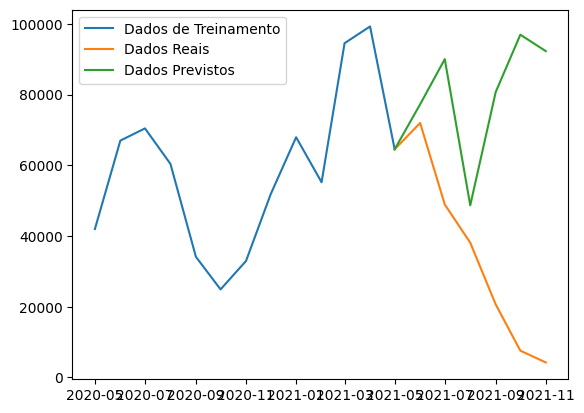

In [224]:
plt.plot(df_features_train["data"], y_train, label = "Dados de Treinamento")

plt.plot([df_features_train["data"].iloc[len(df_features_train["data"]) - 1]] + list(df_features_test["data"]), [y_train[-1][0]] + list(y_test.reshape(1, -1)[0]), label = "Dados Reais")
plt.plot([df_features_train["data"].iloc[len(df_features_train["data"]) - 1]] + list(df_features_test["data"]), [y_train[-1][0]] + list(y_pred.reshape(1, -1)[0]), label = "Dados Previstos")

plt.legend()
plt.show()

In [228]:
df_features_train = df_features.iloc[:13, :]
df_features_test = df_features.iloc[13:, :]

lr = LinearRegression()
x_train = np.array(df_features_train.loc[:, ["covid[-1]", "covid[-2]", "covid[-3]", "clindamicina_mono[-1]", "clindamicina_mono[-2]", "clindamicina_mono[-3]"]])
y_train = np.array(df_features_train.loc[:, ["covid"]])

lr.fit(x_train, y_train)

x_test = np.array(df_features_test.loc[:, ["covid[-1]", "covid[-2]", "covid[-3]", "clindamicina_mono[-1]", "clindamicina_mono[-2]", "clindamicina_mono[-3]"]])
y_test = np.array(df_features_test.loc[:, ["covid"]])
y_pred = lr.predict(x_test)

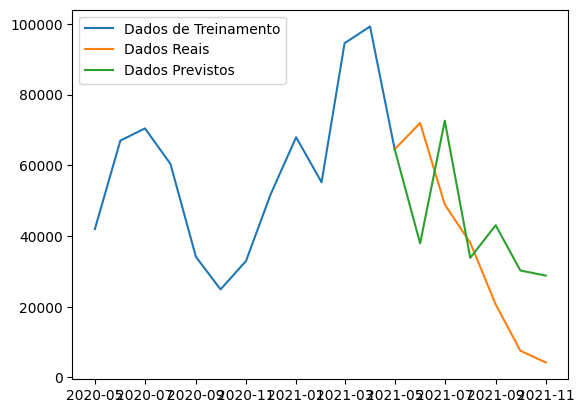

In [229]:
plt.plot(df_features_train["data"], y_train, label = "Dados de Treinamento")

plt.plot([df_features_train["data"].iloc[len(df_features_train["data"]) - 1]] + list(df_features_test["data"]), [y_train[-1][0]] + list(y_test.reshape(1, -1)[0]), label = "Dados Reais")
plt.plot([df_features_train["data"].iloc[len(df_features_train["data"]) - 1]] + list(df_features_test["data"]), [y_train[-1][0]] + list(y_pred.reshape(1, -1)[0]), label = "Dados Previstos")

plt.legend()
plt.show()